<a href="https://colab.research.google.com/github/dianysof/COVID_SQL/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling ------------------------------------------------------

In [53]:
def clean_stopwords(text: str,stop_dict: dict)->str:
    if text is not None:
        words = text.split()
        words_clean = []
        for word in words:
            if word not in stop_dict:
                words_clean.append(word)
        result = ' '.join(words_clean)
    else:
        result = None
    return result

In [54]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013),
# ``Crowdsourcing a Word-Emotion Association Lexicon.''
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html

nrc = pd.read_csv('NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [55]:
nrc

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [56]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate
# Donald Trump used twitter to communicate with potential voters.
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet
# 1.1 Open data and get a glimpse

In [57]:
df_raw = pd.read_csv('trump_tweets.csv')
nltk.download('stopwords')
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3946 entries, 0 to 3945
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          3946 non-null   object
 1   text            3946 non-null   object
 2   created_at      3946 non-null   object
 3   retweet_count   3946 non-null   int64 
 4   favorite_count  3946 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 154.3+ KB


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
# 1.1 Sample some observations
df_raw.sample(10)
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()
# 2.2 Get rid of uninformative columns
#df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [59]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [60]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]
# 2.5 Consider time is UTC, convert to EST
df_interim['created_at'] += pd.Timedelta(-5, unit='h')

In [61]:
# 2.6 Filter source for analysis
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()
# 2.7 Save and create a copy for analysis
df_interim.to_csv('trump_tweets.csv', index=False)
df = df_interim.copy()

In [63]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()
# 3.2 Get a sample
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 3945
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


,source,text,created_at,retweet_count,favorite_count
3679,Twitter for iPhone,I am self funding my campaign so I do not owe ...,2016-01-27 11:21:04,4640,13260
2536,Twitter for iPhone,I am always on the front page of the failing @...,2016-05-28 10:28:48,5266,17285
2929,Twitter for Android,If @megynkelly stopped covering me on her show...,2016-04-01 16:09:29,4034,14524
2046,Twitter for iPhone,AMERICA'S FUTURE\nhttps://t.co/xymiA0Az7x,2016-07-28 10:30:18,3707,11208
2808,Twitter for Android,.@AndreBauer Great job and advice on @CNN @j...,2016-04-24 03:58:53,1643,6402
1122,Twitter for iPhone,"Thank you Reno, Nevada. \nNOTHING will stop us...",2016-11-05 16:03:20,18650,47082
269,Twitter for iPhone,Just put out a very important policy statement...,2015-12-07 11:47:39,2477,5767
2060,Twitter for Android,The Democratic Convention has paid ZERO respec...,2016-07-26 23:50:55,15183,45670
1677,Twitter for iPhone,Thank you Ohio! Just landed in Canton for a ra...,2016-09-14 11:24:01,7996,23750
2686,Twitter for Android,I will be interviewed on This Week with George...,2016-05-08 03:25:28,1660,7643


In [64]:
# 3.3 Describe numerical and datetime data
df.describe(include='all', datetime_is_numeric=True)
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

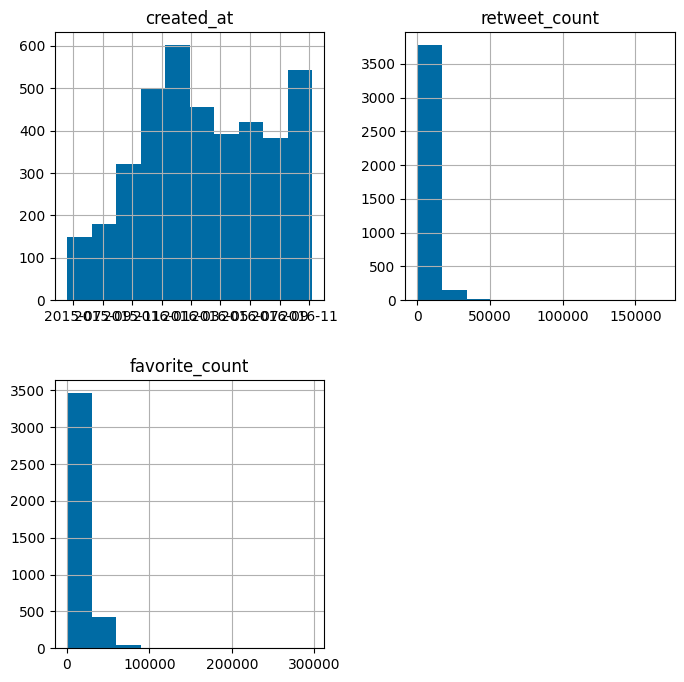

In [65]:
# 3.5 Get histograms for numerical data
df.hist(figsize=(8,8))
plt.show()

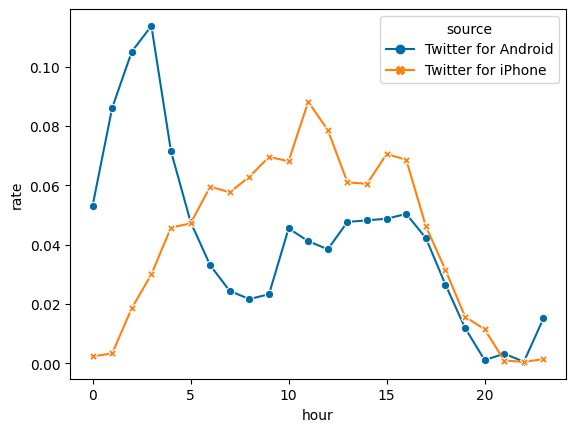

In [66]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
           .assign(hour = df['created_at'].dt.hour)
           .groupby(['source','hour'])
           .agg(count = ('source','count'))
           .assign(rate = lambda df: df['count']/df.groupby('source')['count'].sum())
           .reset_index())
sns.lineplot(data=df_plot, x='hour',y='rate', hue='source',
             markers=True, style='source', dashes=False)
plt.show()

In [67]:

# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count', ascending=False)[['text','retweet_count']][:10]
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count', ascending=False)[['text','favorite_count']][:10]

,text,favorite_count
2446,How long did it take your staff of 823 people ...,297281
2156,Such a great honor to be the Republican Nomine...,129652
1476,Here is my statement. https://t.co/WAZiGoQqMQ,120244
1499,Mike Pence won big. We should all be proud of ...,120189
2711,Happy #CincoDeMayo! The best taco bowls are ma...,119759
1132,MAKE AMERICA GREAT AGAIN!,115387
1545,For those few people knocking me for tweeting ...,107497
1474,The media and establishment want me out of the...,105680
1139,If Obama worked as hard on straightening out o...,102045
2188,I am pleased to announce that I have chosen Go...,92250


In [68]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [69]:
# 3.10 Process text to extract stopwords
df['text_clean'] = df['text'].str.lower()
stop_dict = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x, stop_dict = stop_dict))

tw_pat = "([^A-Za-z\d#@]|'(?![A-Za-z]\d#@))"
df['text_clean'] = df['text_clean'].str.replace(r'','',regex=True)
df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''', '', regex=True)

In [70]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean'] = df['text_clean'].str.replace(url_pat, '', regex=True)
# 3.12 Extract special characters
df['text_clean'] = df['text_clean'].str.replace(r'''[!.,():\-%$/'"‘]''', '', regex=True)
# 3.13 Extract numbers
df['text_clean'] = df['text_clean'].str.replace(r'[\d]+', '', regex=True)

In [71]:
# 3.14 See the results
df[['text','text_clean']].sample(10)

,text,text_clean
642,.@JebBush is totally lost -- he spends too muc...,@jebbush totally lost spends much time managi...
767,"Will be in Nashville, Tennessee, tomorrow (Sat...",nashville tennessee tomorrow saturday pm much...
1361,Hillary is the most corrupt person to ever run...,hillary corrupt person ever run presidency uni...
920,It has just been confirmed by the City of Mob...,confirmed city mobile alabama people last nig...
2171,The ratings at @FoxNews blow away the ratings ...,ratings @foxnews blow away ratings @cnn even ...
3926,"Thank you #Biloxi, #Mississippi! Remember this...",thank #biloxi #mississippi remember night spr...
2642,That was an amazing interview on @foxandfriend...,amazing interview @foxandfriends hope rest me...
569,Anybody that believes in strong borders and st...,anybody believes strong borders stopping illeg...
2561,Goofy Senator Elizabeth Warren @elizabethforma...,goofy senator elizabeth warren @elizabethforma...
3922,Hillary said that guns don't keep you safe. If...,hillary said guns keep safe really believes de...


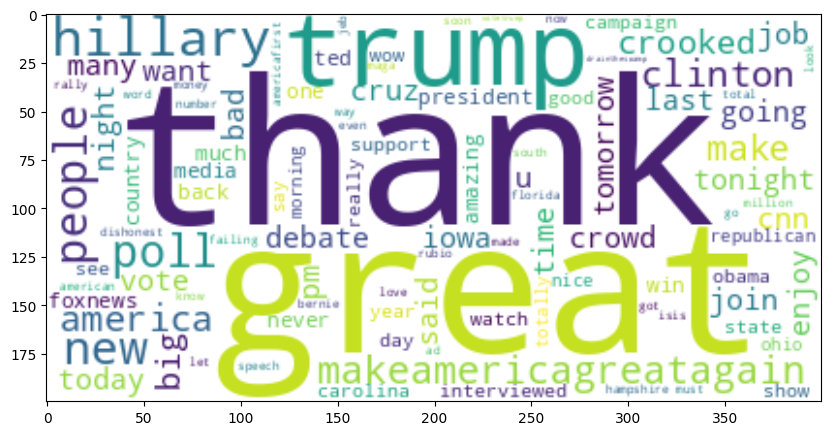

In [72]:
# 3.15 Let's see a wordcloud
text = ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color='White', collocations=False).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [78]:
df

,source,text,created_at,retweet_count,favorite_count,text_clean
0,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 13:21:49,6776,16495,would like wish everyone happy healthy new yea...
1,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 13:11:35,2755,6824,believe state department new years eve release...
2,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 08:51:12,2468,6047,thank illinois lets forget get family friends...
3,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 06:52:38,2080,8416,happy birthday son @donaldjtrumpjr proud you #...
4,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 05:07:18,1875,5780,would feel sorry @jebbush badly campaign fact ...
...,...,...,...,...,...,...
3941,Twitter for Android,"Well, the year has officially begun. I have ma...",2016-01-01 13:00:09,2642,8495,well year officially begun many stops planned ...
3942,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2015-12-31 20:07:28,1948,8258,happy new year #maralago thank great family su...
3943,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2015-12-31 19:18:23,3434,9143,#happynewyearamerica httpstcoeeqbpdrue
3944,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2015-12-31 17:25:27,3460,8581,happy new year thank you httpstcoyoyiqbzy htt...


In [ ]:
# 3.15 Let's see a wordcloud
text = ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color='White', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

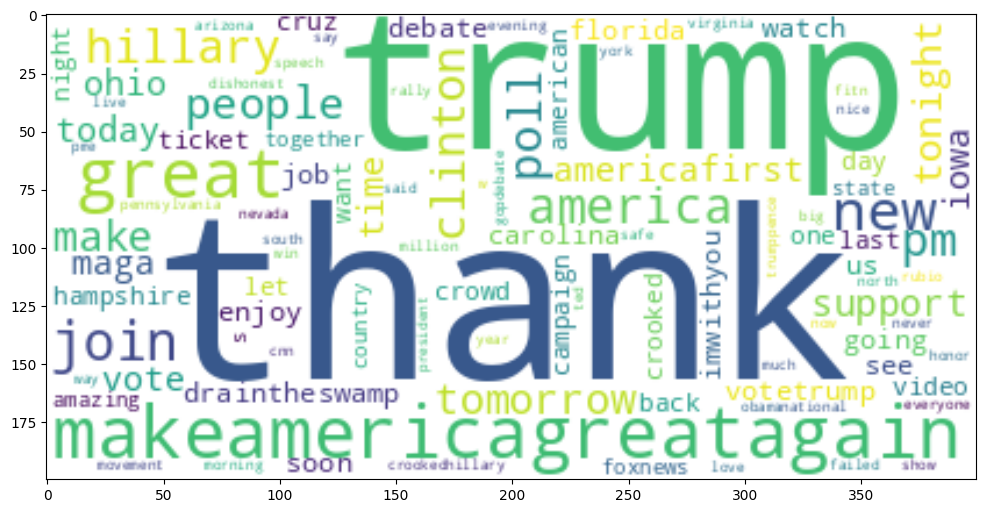

In [80]:
# 3.15 Let's see a wordcloud Iphone
text = ' '.join(i for i in df[df['source']=='Twitter for iPhone'].text_clean)
wordcloud = WordCloud(max_words=100, background_color='White', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

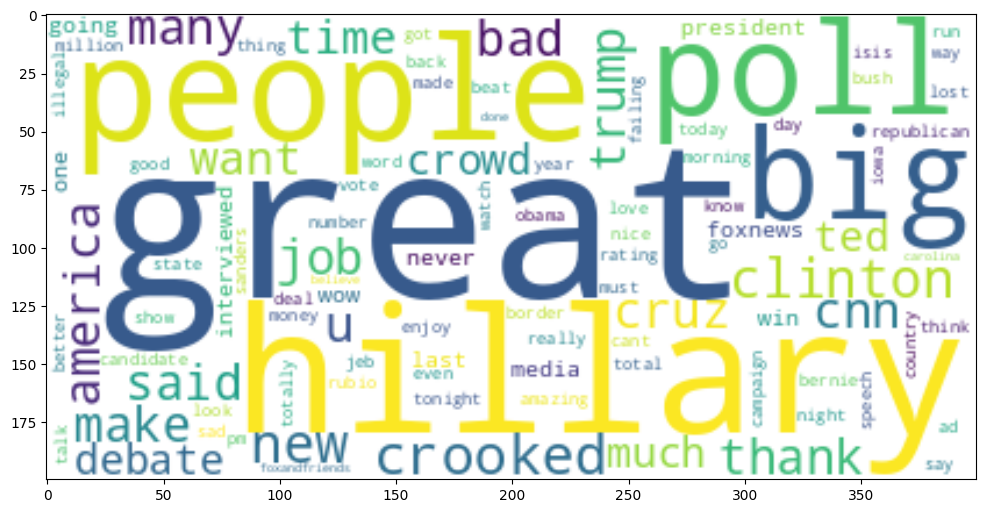

In [81]:
# 3.15 Let's see a wordcloud ANDROID
text = ' '.join(i for i in df[df['source']=='Twitter for Android'].text_clean)
wordcloud = WordCloud(max_words=100, background_color='White', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

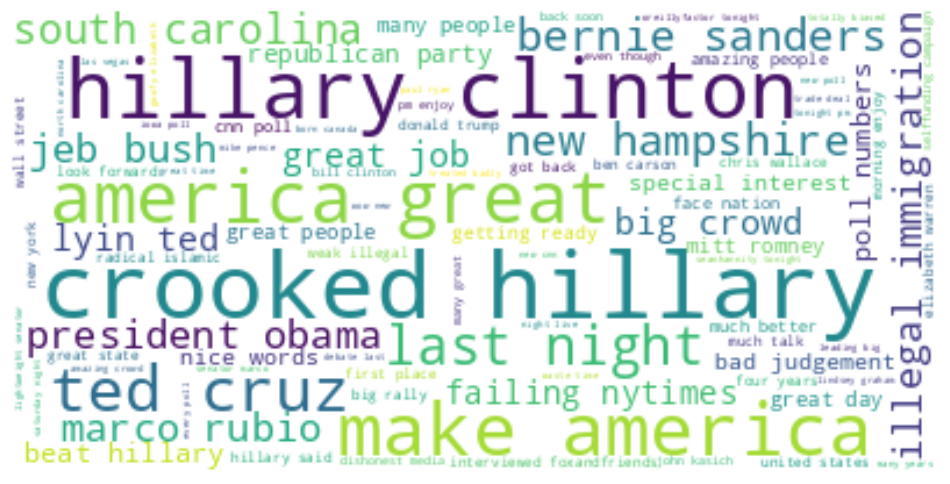

In [82]:
# 3.16 Wordcloud with bigrams 2 words "i love pizza": [(i,love),(love, pizza),(pizza,very),(very much)]
wordcloud = WordCloud(collocation_threshold=2, collocations=True,
max_words=100, background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [83]:
df_word_split = (df
                .drop(['text','created_at','retweet_count','favorite_count'], axis=1)
                .assign(text = df['text_clean'].str.split())).explode('text').\
                    drop('text_clean', axis=1).\
                        rename(columns={'text':'word'})
df_word_split

,source,word
0,Twitter for Android,would
0,Twitter for Android,like
0,Twitter for Android,wish
0,Twitter for Android,everyone
0,Twitter for Android,happy
...,...,...
3945,Twitter for Android,together
3945,Twitter for Android,make
3945,Twitter for Android,america
3945,Twitter for Android,great


In [84]:
df_word_split[df_word_split['source']=='Twitter for Android'].word.value_counts()

great        359
hillary      285
people       194
big          168
crooked      156
            ... 
cartels        1
unimpeded      1
vacuum         1
cleaner        1
ring           1
Name: word, Length: 4252, dtype: int64

In [85]:
df_word_split[df_word_split['source']=='Twitter for iPhone'].word.value_counts()

thank                     607
#trump                    412
#makeamericagreatagain    292
great                     281
you                       208
                         ... 
httpstcoqnqqoqkh            1
icymi                       1
worked;                     1
httpstcoxuwauenkh           1
httpstcouxuxwjrbv           1
Name: word, Length: 5964, dtype: int64

In [93]:
df_word_split.groupby(['source', 'word'],observed=True).agg(count = ('word', 'count')).\
reset_index().merge(nrc[ [ 'word', 'sentiment']], on='word', how='inner').\
drop(['word', 'count'], axis=1)[ 'sentiment'].value_counts()

positive        740
negative        681
trust           453
fear            349
sadness         328
anger           324
anticipation    296
joy             243
disgust         212
surprise        169
Name: sentiment, dtype: int64

In [109]:
df_sentiment = df_word_split.merge(nrc[['word', 'sentiment']], on='word', how='inner').\
groupby(['source', 'sentiment']).agg(count = ('sentiment', 'count')).\
reset_index().pivot_table(index=['sentiment'], columns=['source'], values='count').\
reset_index().rename(columns={'Twitter for Android': 'Android', 'Twitter for iPhone': 'iPhone'})
df_sentiment

source,sentiment,Android,iPhone
0,anger,949,515
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,544
5,negative,1671,926
6,positive,1963,1524
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1024


In [98]:
df_odd_ratio = df_sentiment.\
assign(odds_ratio=(df_sentiment['Android']/(df_sentiment['Android'].sum() - df_sentiment['Android'])) / (df_sentiment['iPhone']/(df_sentiment[ 'iPhone'].sum() - df_sentiment['iPhone'])))

In [100]:
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odds_ratio'])
df_odd_ratio

source,sentiment,Android,iPhone,odds_ratio,log_or
0,anger,949,515,1.224033,0.202151
1,anticipation,986,725,0.877210,-0.131009
2,disgust,632,307,1.366925,0.312564
3,fear,815,477,1.126052,0.118718
4,joy,743,544,0.884312,-0.122946
5,negative,1671,926,1.212501,0.192685
6,positive,1963,1524,0.805687,-0.216060
7,sadness,911,512,1.177829,0.163673
8,surprise,587,385,0.995985,-0.004023
9,trust,1363,1024,0.850512,-0.161917


In [105]:
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android'] + 1/(df_odd_ratio['Android'].sum() - df_odd_ratio['Android']) +
                             1/df_odd_ratio['iPhone'] +1/(df_odd_ratio['iPhone'].sum() + df_odd_ratio['iPhone']))

df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or'] + norm.ppf(0.975)*df_odd_ratio['se']

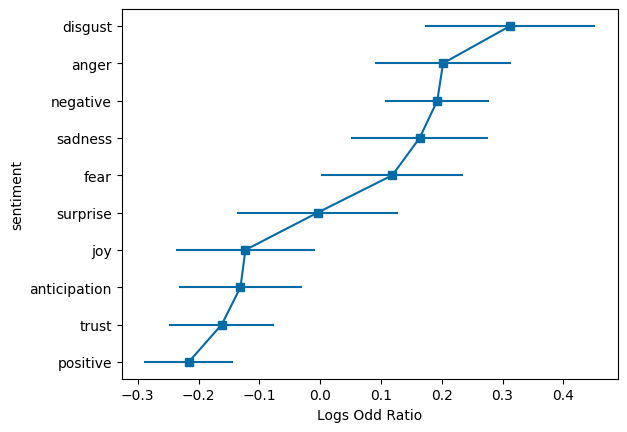

In [108]:
df_odd_ratio = df_odd_ratio.sort_values(by='log_or', ascending=True)

plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'], xerr = ((df_odd_ratio.log_or - df_odd_ratio.conf_low),(df_odd_ratio.conf_high - df_odd_ratio.log_or )), marker='s')
plt.xlabel('Logs Odd Ratio')
plt.ylabel('sentiment')
plt.show()